W tym zadaniu zajmiemy się ekstrakcją melowo-częstotliwościowych współczynników cepstralnych (MFCC).

MFCC to cechy bardzo często ekstrahowane z sygnałów akustycznych z zakresu słyszalnego, głównie sygnału mowy. Uzyskiwane są poprzez filtrację cepstrum (cepstrum - odwrotna transformata Fouriera z widma wyrażonego w skali logarytmicznej) bankiem filtrów trójkątnych. Filtry te są dobrane tak, by w (dużym) przybliżeniu modelować odpowiedź układu słuchowego człowieka na sygnał akustyczny. Rodzielczość częstotliwościowa słuchu jest wyższa dla niskich częstotliwości, a niższa dla wysokich, więc filtry melowe są węższe dla niskich częstotliwości i szersze dla wysokich.

Algorytm ekstrakcji MFCC jest w skórcie opisany np. tutaj: https://sound.eti.pg.gda.pl/student/amowy/AM_07_ASR.pdf (slajdy 8-11).

1. Wyświetl spektrogram dowolnego sygnału z poprzedniego zadania (folder dane_testowe).

(129, 145)


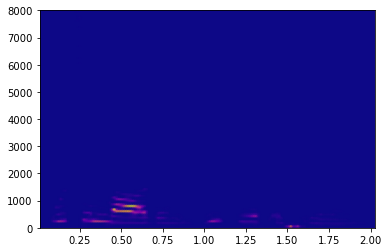

In [1]:
from scipy.io.wavfile import read as read_wav
from scipy.signal import spectrogram
import numpy as np
import matplotlib.pyplot as plt

fs, signal = read_wav('dane_testowe/1-phrase.wav')

f, t, Sxx = spectrogram(signal, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='plasma')

print(np.shape(Sxx))

In [2]:
print(len(signal))
print(fs)

32583
16000


2. Wyznacz MFCC dla tego samego sygnału - poniżej fragment kodu, który możesz użyć.

Wariant 1 - użycie sygnału wczytanego przy użyciu biblioteki scipy

In [3]:
import librosa

mfcc_20_coeffs = librosa.feature.mfcc(signal.astype(float), sr=fs) #signal.astype(float) oznacza, że zmieniamy
#typ danych zapisanych w zmiennej signal na liczby zmiennoprzecinkowe - scipy wczytuje je jako całkowite (int),
#a librosa potrzebuje danych typu float

print(mfcc_20_coeffs.shape) #pierwszy wymiar - liczba współczynników MFCC, drugi - liczba ramek sygnału

(20, 64)


Wariant 2 - wczytywanie sygnału przy użyciu biblioteki librosa

In [4]:
signal, fs = librosa.load('dane_testowe/1-phrase.wav', sr=None) #trzeba zdefiniować częstotliwość próbkowania jako None,
# bo inaczej librosa przyjmuje wartość domyślną, czyli 22050 i modyfikuje sygnał przy wczytywaniu

mfcc_20_coeffs = librosa.feature.mfcc(signal, sr=fs)

print(mfcc_20_coeffs.shape) #pierwszy wymiar - liczba współczynników MFCC, drugi - liczba ramek sygnału

(20, 64)


In [5]:
print(len(signal))
print(fs)

32583
16000


In [6]:
#dla porównania co się stanie, jeżeli nie wpiszemy sr=None
signal2, fs2 = librosa.load('dane_testowe/1-phrase.wav')

print(len(signal2))
print(fs2)

44904
22050


Liczba współczynników jest domyślnie ustawiona na 20 i można ją zmienić podając do funkcji argument n_mfcc. Najmniejszą często używaną liczbą współczynników jest 13. 

In [7]:
mfcc_13_coeffs = librosa.feature.mfcc(signal, sr=fs, n_mfcc=13)
print(mfcc_13_coeffs.shape)

(13, 64)


3. Wyświetl MFCC jako obraz (funkcja imshow()). Porównaj wygląd obu obrazów oraz ich wymiary.

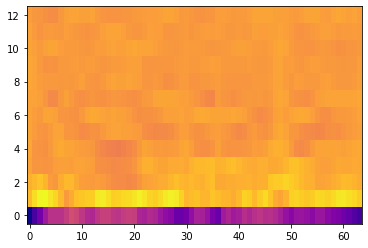

In [8]:
plt.imshow(mfcc_13_coeffs, cmap='plasma', aspect='auto') #aspect=auto powoduje, że kształt pikseli jest inny
                                                        #i zazwyczaj obraz wygląda bardziej czytelnie
plt.gca().invert_yaxis()

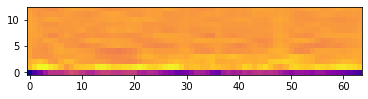

In [9]:
plt.imshow(mfcc_13_coeffs, cmap='plasma')
plt.gca().invert_yaxis()

[Text(0.5, 1.0, 'MFCC')]

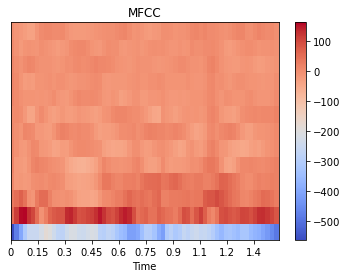

In [10]:
#wyświetlanie przy pomocy librosy - na osi x będzie czas w sekundach
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc_13_coeffs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax) #obok obrazu będzie wyświetlony pasek ze skalą kolorystyczną
ax.set(title='MFCC')

4. Wytrenuj klasyfikator analogicznie do zadania 1, ale tym razem na MFCC, a nie na spektrogramach (użyj części kodu z poprzedniego zadania). Pamiętaj o zachowaniu takiego samego podziału sygnałów na zbiory uczący i testowy (w poprzednim zadaniu trzeba było zapisać listę plików w obu zbiorach do plików - możesz ich użyć dla pewności lub zastosować taki sam random_state w funkcji train_test_split).

In [11]:
#wariant z przycinaniem zbyt długich sygnałów - można zrobić zero-padding analogicznie do tego w zadaniu 1
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pickle

path = 'dane_testowe/'
ids_to_get = [1, 10, 95, 110, 121, 144, 676, 699, 888, 910, 1182, 1204, 1207, 1528, 1860, 1897, 1972, 2102, 2152, 2444] 
list_of_files = []
for directory, subdirs, files in os.walk(path):
    list_of_files.extend([file for file in files for i in ids_to_get if file.startswith(str(i)+'-') if file.endswith('.wav')])
files_with_phrase = [file for file in list_of_files if 'phrase' in file]

mfccs = []
sig_len = []
for file in files_with_phrase:
    x, fs = librosa.load(path+file)
    mfcc_13_coeffs = librosa.feature.mfcc(x, sr=fs, n_mfcc=13)
    mfccs.append(mfcc_13_coeffs)
    sig_len.append(np.shape(mfcc_13_coeffs)[1])
trunc_mfccs = []
for item in mfccs:
    item = item[:, :np.min(sig_len)]
    trunc_mfccs.append(item)
mfccs = np.asarray(trunc_mfccs)

labels = np.zeros(len(files_with_phrase))
ID = [110, 144, 888, 910, 1204, 1897, 1972, 2102, 2152, 2444]
for count, value in enumerate(files_with_phrase):
    for i in ID:
        if value.startswith(str(i)+'-'):
            labels[count] = 1
            
X_train, X_test, y_train, y_test = train_test_split(mfccs, labels, test_size=0.2, random_state=42, stratify=labels)

X_train = X_train.reshape(np.shape(X_train)[0],-1)
X_train.shape
X_test = X_test.reshape(np.shape(X_test)[0],-1)

In [12]:
#klasyfikacja
clf = KNeighborsClassifier(n_neighbors=7) #liczba sąsiadów nie musi być taka sama jak w zadaniu 1 - każde cechy 
#wymagają osobnego doboru liczby sąsiadów tak, by wyniki były jak najlepsze
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
preds

array([0., 0., 1., 1.])

5. Wylicz metryki sukcesu i oceń, czy zmiana rodzaju użytych cech sygnału ma wpływ na wyniki.

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

acc = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds)
prec = precision_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(acc, recall, prec, f1)

1.0 1.0 1.0 1.0
